In [1]:
!nvidia-smi
%matplotlib inline

Mon Jul  7 12:34:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   30C    P0             49W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import requests

# HotpotQA 正确的官方数据地址（来自 CMU）
urls = {
    "train": "http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_train_v1.1.json",
    "dev": "http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json"
}

for split, url in urls.items():
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"hotpot_data/hotpot_{split}.json", "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"{split} 集下载成功 ✅")
    else:
        print(f"{split} 集下载失败 ❌，状态码: {response.status_code}")

train 集下载成功 ✅
dev 集下载成功 ✅


In [1]:
import json
from datasets import Dataset


with open("hotpot_data/hotpot_train.json", "r", encoding="utf-8") as t:
    train_data = json.load(t)
with open("hotpot_data/hotpot_dev.json", "r", encoding="utf-8") as d:
    dev_data = json.load(d)

In [2]:
print(len(train_data))
print(len(dev_data))

90447
7405


In [6]:
dev_data[1]

{'_id': '5a8c7595554299585d9e36b6',
 'answer': 'Chief of Protocol',
 'question': 'What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?',
 'supporting_facts': [['Kiss and Tell (1945 film)', 0],
  ['Shirley Temple', 0],
  ['Shirley Temple', 1]],
 'context': [['Meet Corliss Archer',
   ["Meet Corliss Archer, a program from radio's Golden Age, ran from January 7, 1943 to September 30, 1956.",
    ' Although it was CBS\'s answer to NBC\'s popular "A Date with Judy", it was also broadcast by NBC in 1948 as a summer replacement for "The Bob Hope Show".',
    ' From October 3, 1952 to June 26, 1953, it aired on ABC, finally returning to CBS.',
    " Despite the program's long run, fewer than 24 episodes are known to exist."]],
  ['Shirley Temple',
   ["Shirley Temple Black (April 23, 1928 – February 10, 2014) was an American actress, singer, dancer, businesswoman, and diplomat who was Hollywood's number one box-office draw as a child actress fr

In [5]:
task_relevant_data = [{"id": item["_id"], "question": item["question"], "answer": [item["answer"]]} for item in dev_data]
task_relevant_data_hf = Dataset.from_list(task_relevant_data)

In [6]:
hotpot_sample = task_relevant_data_hf.shuffle(seed=42).select(range(1000))

In [7]:
hotpot_sample[0]

{'id': '5add1d575542992c1e3a2540',
 'question': "What nationality was Oliver Reed's character in the film Royal Flash?",
 'answer': ['Prussian']}

In [8]:
hotpot_sample.to_json("hotpot_sample_raw.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

170940

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# Classifying questions using the DSPy program

## Loading the model

In [9]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)
dspy.configure(lm=model)

## Helper functions

In [10]:
def run_batch(batch, class_to_use):
    results = []
    for request in batch["question"]:
        try:
            result = class_to_use(request=request)
            results.append({
                "category": result.category,
                "judgment": result.judgment,
                "reasoning": getattr(result, "reasoning", "")
            })
        except Exception as e:
            results.append({
                "category": "error",
                "judgment": "error",
                "reasoning": "error"
            })
    return {
        "category": [r["category"] for r in results],
        "judgment": [r["judgment"] for r in results],
        "reasoning": [r["reasoning"] for r in results]
    }



def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

def collect_thinking_streaming(loaded_model, output_path):
    history_data = loaded_model.history
    print(f'The current length of history is {len(history_data)}.')

    with open(output_path, 'w', encoding='utf-8') as f:
        for record in history_data:
            thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
            json.dump({"thinking": thinking}, f)
            f.write('\n')


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

## Loading the DSPy program from Exp 2

In [11]:
loaded_dspy_program = dspy.load("../Reproductivity/dspy_program/")
# Encapsule the loaded program into the batch running function
wrapped_batch = partial(run_batch, class_to_use=loaded_dspy_program)

In [12]:
# batch parameters
batch_size = 5
num_samples = len(hotpot_sample)
batches = [hotpot_sample.select(range(i, min(i + batch_size, num_samples))) for i in range(0, num_samples, batch_size)]

# Initialize a dict of outputs with empty lists using designated keys
all_outputs = {"category": [], "judgment": [], "reasoning": []}

# tqdm progress bar
for batch in tqdm(batches, desc="Running DSPy classification"):
    out = wrapped_batch(batch)
    for key in all_outputs:
        all_outputs[key].extend(out[key])

Running DSPy classification: 100%|██████████| 200/200 [2:25:46<00:00, 43.73s/it]  


In [13]:
# Integrate outputs into the original dataset (copy)
annotated_dataset = add_columns_to_dataset(hotpot_sample, all_outputs)

# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("classified_HotpotQA_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("classified_HotpotQA_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("classified_HotpotQA_sample_FS.jsonl", orient="records", lines=True)

Flattening the indices:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 394
Fully specified samples: 606


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

372933

In [14]:
annotated_dataset[0]

{'id': '5add1d575542992c1e3a2540',
 'question': "What nationality was Oliver Reed's character in the film Royal Flash?",
 'answer': ['Prussian'],
 'category': 'fully specified',
 'judgment': 'fully specified',
 'reasoning': 'This question is fully specified because it refers to a specific film ("Royal Flash") and a well-known actor (Oliver Reed), asking for the nationality of his character. The referent is unambiguous, the scope is factual, and no missing components or subjective criteria are involved.'}

In [15]:
# Collect thinking
think_list = collect_thinking(model)
print(f"The number of thinking pieces is {len(think_list)}.")
think_df = pd.DataFrame(think_list)
think_df.to_csv('think_HotpotQA_sample.csv')

collect_thinking_streaming(model, "think_HotpotQA_sample.jsonl")

The current length of history is 1161.
The number of thinking pieces is 1161.
The current length of history is 1161.


In [16]:
df = pd.read_json("classified_HotpotQA_sample_all.jsonl", lines=True)
df.to_csv('classified_HotpotQA_sample_all.csv')
df

,id,question,answer,category,judgment,reasoning
0,5add1d575542992c1e3a2540,What nationality was Oliver Reed's character i...,[Prussian],fully specified,fully specified,This question is fully specified because it re...
1,5ac55ea55542993e66e82377,Pacific Mozart Ensemble performed which German...,[Kurt Julian Weill],fully specified,fully specified,This question is fully specified because it re...
2,5ac3a76e554299741d48a2be,"Who released the song ""With or Without You"" fi...",[U2],Undetermined lexicons or references,underspecified,The request is underspecified because the refe...
3,5a7133565542994082a3e65c,"What Kentucky county has a population of 60,31...",[Oldham County],Undetermined lexicons or references,underspecified,The request is underspecified because the term...
4,5ac1a4745542991316484b82,"Para Hills West, South Australia lies within a...","[138,535]",fully specified,fully specified,This question is fully specified because it re...
...,...,...,...,...,...,...
995,5a8b46925542995d1e6f133c,When was the singer of Miss Emily's Picture born?,"[August 11, 1946]",Undetermined lexicons or references,underspecified,The request is underspecified because the refe...
996,5a808cbd5542996402f6a54b,What is the profession of Ansel Elgort's chara...,[getaway driver],fully specified,fully specified,This question is fully specified because it re...
997,5ab1e7685542993be8fa9877,On what street was the hotel located where the...,[Peachtree Street],Undetermined lexicons or references,underspecified,The request is underspecified because the refe...
998,5a865d11554299211dda2b0d,What is the original name of the place where T...,[Fort Saint Anthony],Undetermined lexicons or references,underspecified,The request is underspecified because the term...


# QA implementations

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="classified_HotpotQA_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="classified_HotpotQA_sample_FS.jsonl",
    split="train"
)

## Loading GPT for short QA

In [3]:
from openai import OpenAI

client = OpenAI(
    api_key="",
    base_url="https://api.openai.com/v1"
) # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return ["[Error]: Max retries exceeded"]

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

In [6]:
def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=5, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

## Implementations

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 79/79 [03:52<00:00,  2.94s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 122/122 [05:27<00:00,  2.69s/it]


In [10]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])

qa_underspecified.to_json("HotpotQA_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

279750

In [11]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])
    
qa_fully_specified.to_json("HotpotQA_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

402483

In [12]:
df = pd.read_json("HotpotQA_UND_qa_gpt.jsonl", lines=True)
df.to_csv('HotpotQA_UND_qa_gpt.csv')

df = pd.read_json("HotpotQA_FS_qa_gpt.jsonl", lines=True)
df.to_csv('HotpotQA_FS_qa_gpt.csv')

# Evaluations

In [2]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="HotpotQA_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="HotpotQA_FS_qa_gpt.jsonl",
    split="train"
)

## Squad EM + F1

In [3]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="HotpotQA_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["answer"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 38.61
F1 Score: 51.89


In [4]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="HotpotQA_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["answer"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 21.83
F1 Score: 35.40


In [5]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="answer"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [6]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("HotpotQA_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

286664

In [7]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("HotpotQA_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

413079

In [8]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 22.08
UND F1 Score (avg): 35.72
FS Exact Match (avg): 38.94
FS F1 Score (avg): 52.49
F1: t=6.170, p=0.0000
EM: t=5.850, p=0.0000


In [3]:
UND_full = load_dataset(
    "json",
    data_files="HotpotQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="HotpotQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

In [2]:
df = pd.read_json("HotpotQA_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('HotpotQA_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("HotpotQA_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('HotpotQA_FS_qa_gpt_with_squad_scores.csv')

In [3]:
print(f'gpt_4o HotpotQA NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o HotpotQA NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o HotpotQA NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o HotpotQA NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o HotpotQA NQ UND qa EM SD: 0.4147941208530088
gpt_4o HotpotQA NQ FS qa EM SD: 0.48762306433639085
gpt_4o HotpotQA NQ UND qa F1 SD: 0.4079821779434008
gpt_4o HotpotQA NQ FS qa F1 SD: 0.43666341470616715


In [4]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [5]:
welch_df(394, np.std(UND_full["em"]), 606, np.std(FS_full["em"]))

929.2090378182792

In [6]:
welch_df(394, np.std(UND_full["f1"]), 606, np.std(FS_full["f1"]))

879.495758403792

## Visualization

In [9]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset - HotpotQA")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("HotpotQA_f1_boxplot_gpt.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset (± CI) - HotpotQA")
plt.tight_layout()
plt.savefig("HotpotQA_em_barplot_gpt.png",dpi=300)
plt.close()

/scratch-local/yhuang.13034533/ipykernel_1301376/1665096230.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.13034533/ipykernel_1301376/1665096230.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.13034533/ipykernel_1301376/1665096230.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


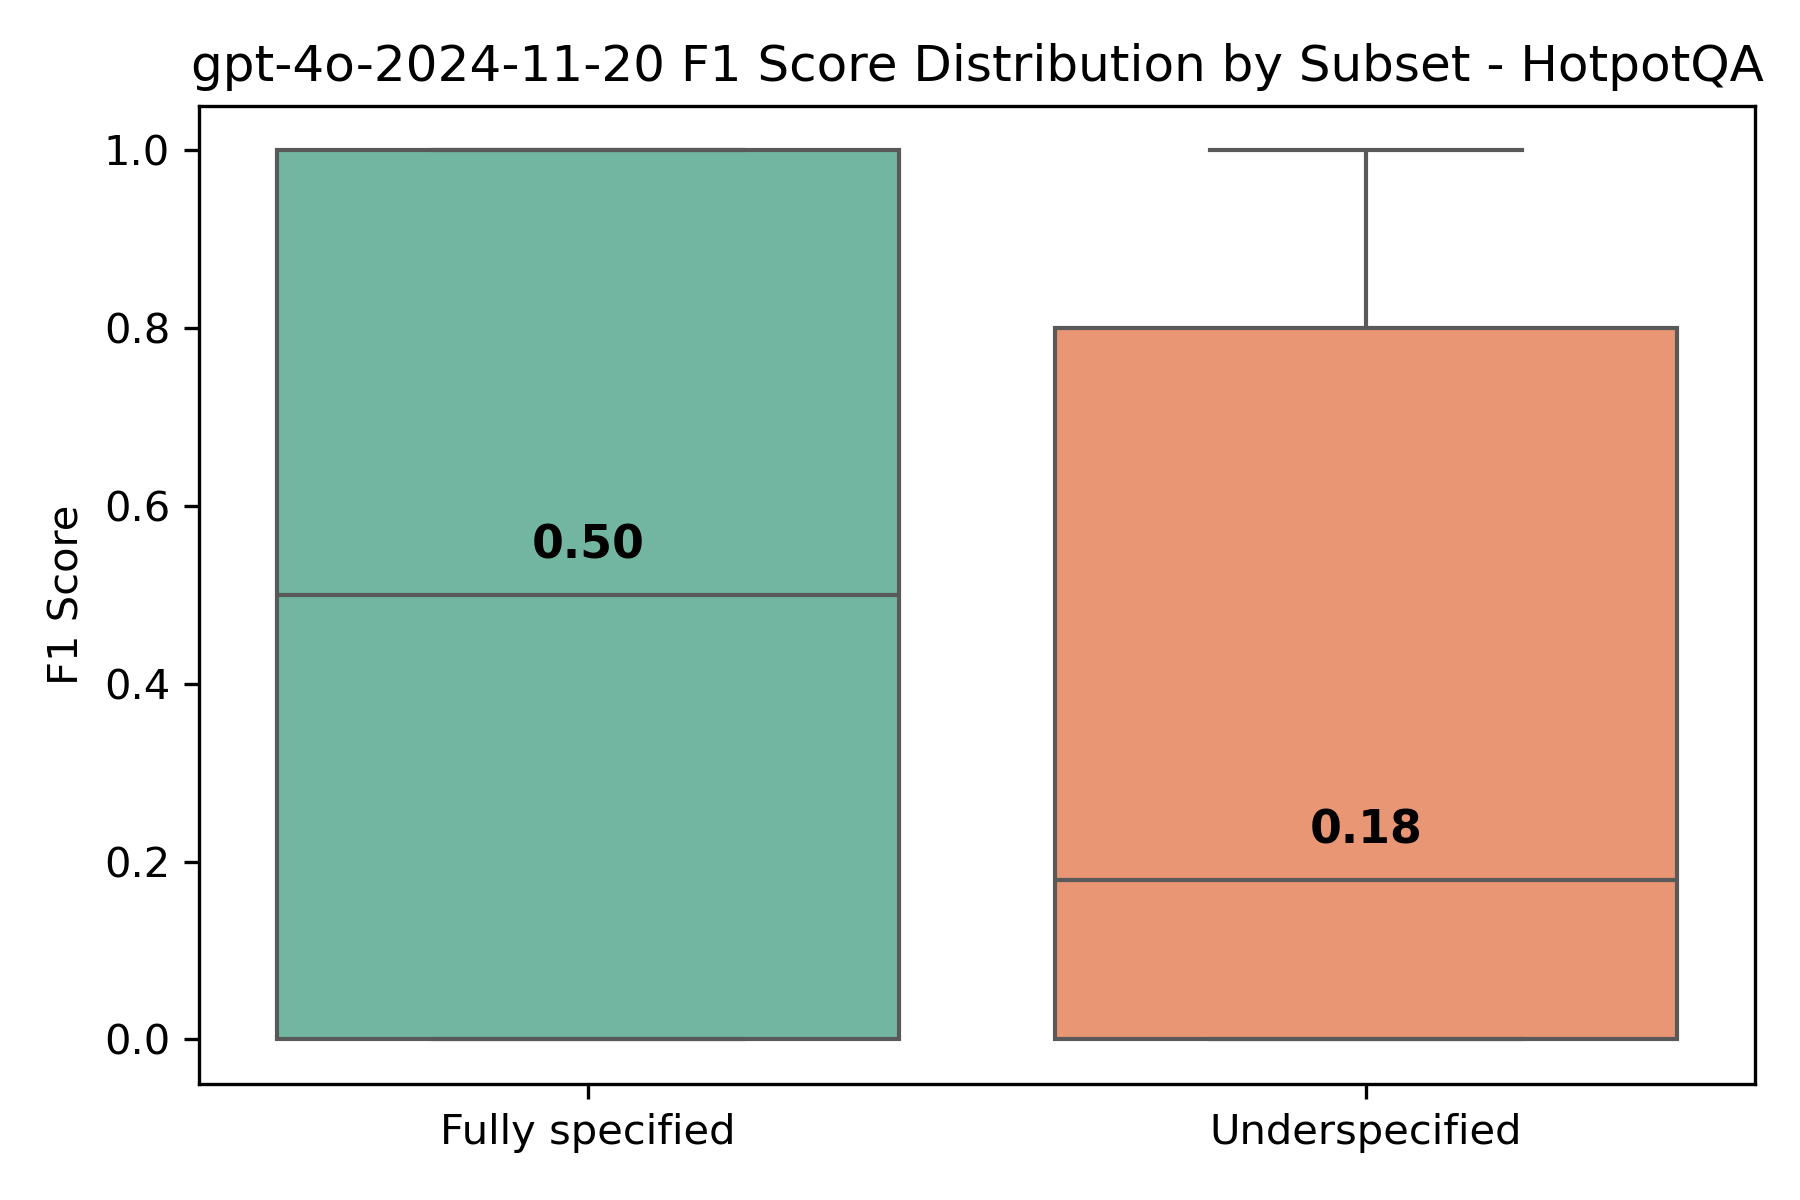

In [10]:
from IPython.display import Image
Image("HotpotQA_f1_boxplot_gpt.png")

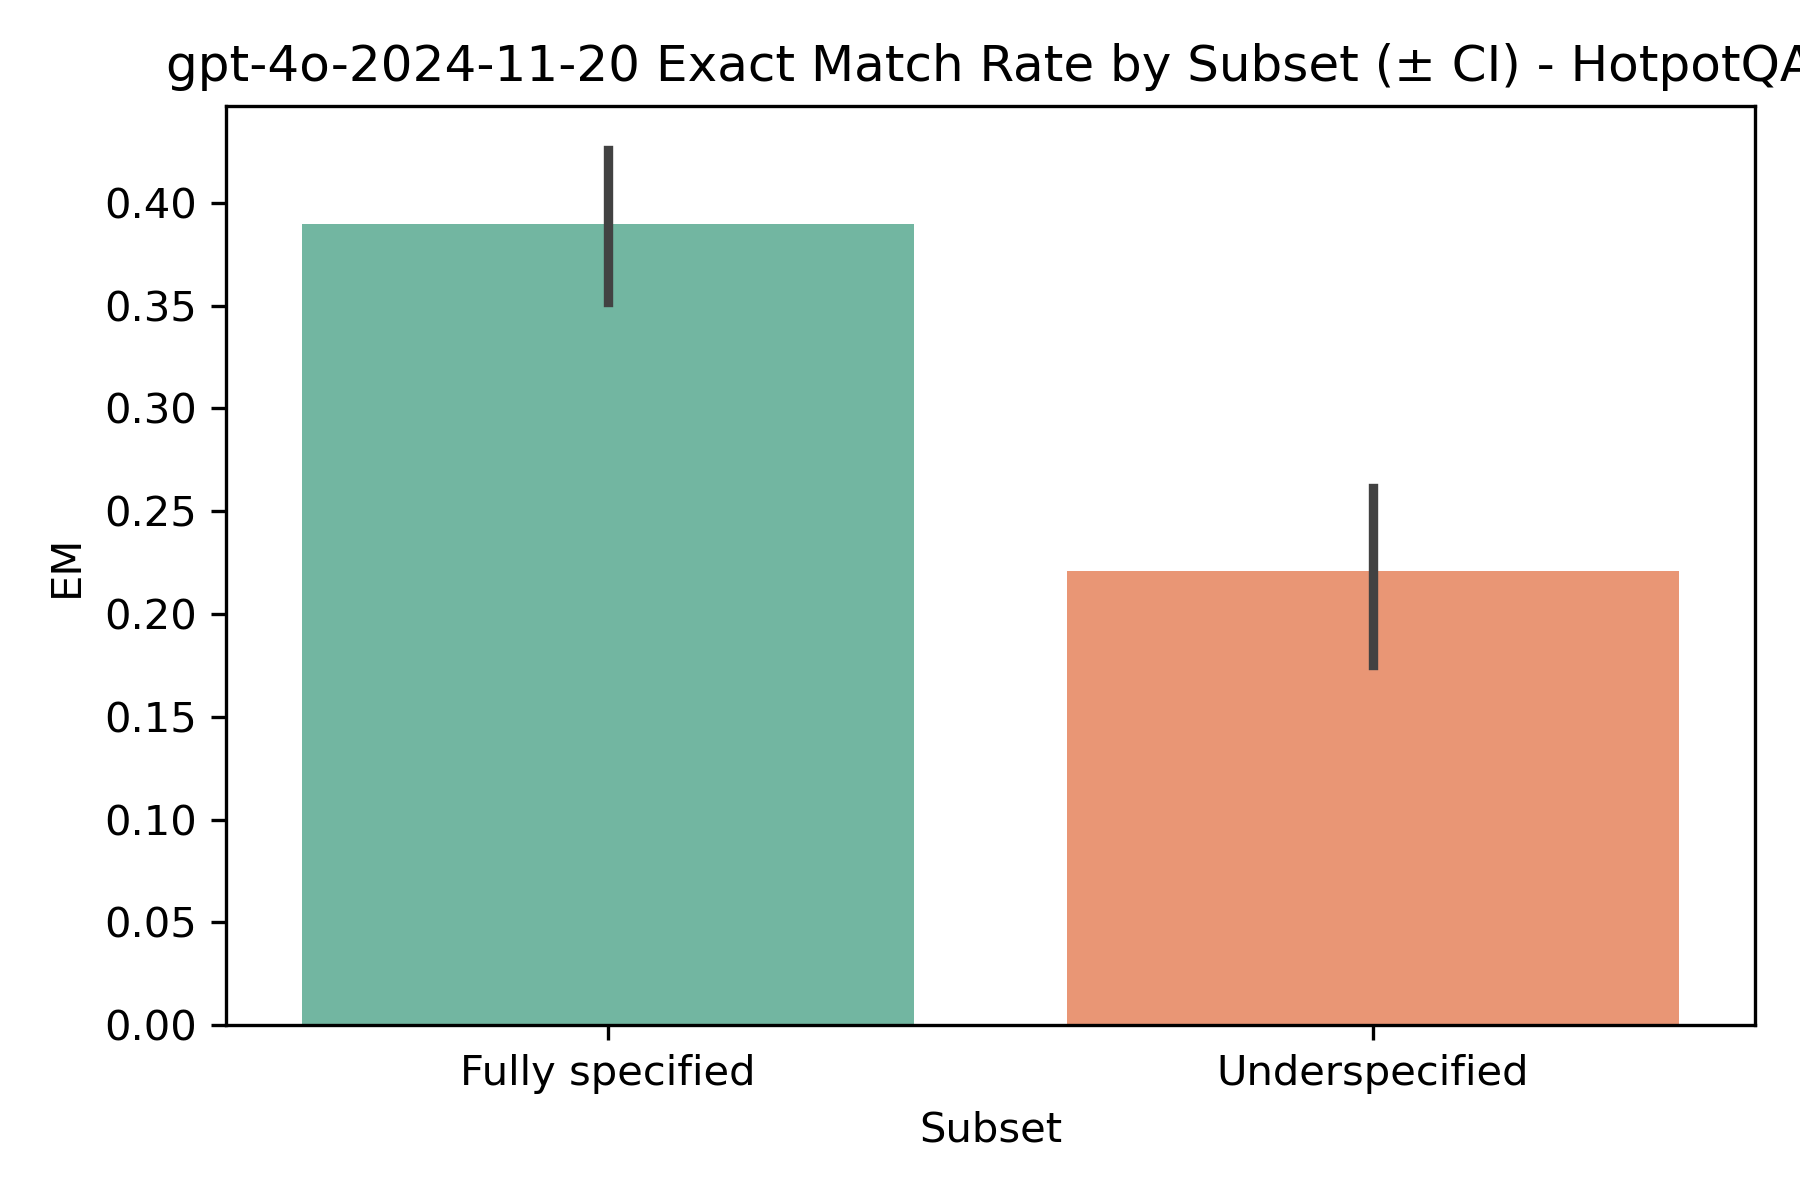

In [11]:
Image("HotpotQA_em_barplot_gpt.png")